<a href="https://colab.research.google.com/github/SowmyaAnilkumar/masters_dissertation/blob/main/Hybrid_midsem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

torch_version = format_pytorch_version(torch.__version__)
CUDA_version = torch.version.cuda

!pip install torch-scatter==latest+cu{CUDA_version.replace('.', '')} torch-sparse==latest+cu{CUDA_version.replace('.', '')} -f https://data.pyg.org/whl/torch-{torch_version}.html
!pip install torch_geometric

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install torch-scatter==latest+cu{CUDA_version.replace('.', '')} torch-sparse==latest+cu{CUDA_version.replace('.', '')} -f https://data.pyg.org/whl/torch-{torch_version}.html'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00


In [2]:
pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv
from sklearn.metrics import (precision_recall_curve, auc, f1_score,
                             precision_score, recall_score, roc_auc_score, brier_score_loss,
                             roc_curve)
from sklearn.calibration import calibration_curve



# Initial Data & Observations (Pointer Summary)

## Data Source
The study leverages heuristically generated customer interaction data derived from Verizon’s **AEP (Adobe Experience Platform)** ecosystem. The dataset represents three months of customer activity, capturing digital touchpoints across Verizon’s online channels.

## Event-Level Analysis
Customer behavior is modeled using event-based interactions, where each event represents a meaningful action taken by a customer within the Verizon ecosystem. The most frequently observed core event categories include:
1.  **Page View**
2.  **Promotion (Promo)**
3.  **Purchase**
4.  **Search**
5.  **Troubleshooting**

### Event Semantics & Journeys
*   **Page View Events**: Represent customer visits to specific digital pages such as Accessibility, 5G homepage, Billing, and ad-fund pages. These capture passive exploration.
*   **Promotion (Promo) Events**: Capture customer exposure to offers, discounts, or promotional content.
*   **Purchase Events**: Reflect transactional actions (product or plan purchases).
*   **Troubleshooting Events**: Correspond to customer-initiated issue resolution (Incident numbers, Support interactions), indicating friction.
*   **Search Events**: Capture keywords/topics actively searched by customers (intent).

## Journey Formation
Each event category encompasses multiple customer journeys. Events are treated as nodes in a temporal interaction sequence, forming the basis for **downstream predictive and graph-based modeling**.

## Event Selection for Modeling
From the full event universe, top-occurring and high-impact events are selected to enable:
*   Behavioral pattern discovery
*   Journey transitions
*   Downstream predictive modeling (Hybrid GNN-Transformer)



In [ ]:


# =================================================================
# 1. SCHEMA & DATA SIMULATION (INTRODUCING NOISE & OVERLAP)
# =================================================================
VERIZON_EVENT_MAP = {
    "FRICTION": [
        "pageview:404", "pageview:error", "trouble:context", "error:payment_declined", "error:login_failed",
        "error:server_timeout", "error:form_validation", "scen:device_reboot_instr", "scen:router_reset_fail",
        "scen:ota_activation_fail", "pageview:service_outage_map", "alert:network_congestion", "popup:session_expired",
        "pageview:forgot_password", "pageview:forgot_userid", "action:retry_payment", "action:resend_otp",
        "pageview:cart_error", "api:500_internal_error", "pageview:order_failed", "trouble:ticket_creation",
        "pageview:appointment_reschedule_fail"
    ],
    "BILLING": [
        "pageview:bill", "pageview:pay", "pageview:history", "pageview:autopay_enroll", "pageview:autopay_manage",
        "pageview:payment_methods", "action:add_credit_card", "action:download_bill_pdf", "pageview:usage_overview",
        "pageview:data_utilization", "pageview:call_log", "pageview:paperless_settings", "pageview:promise_to_pay",
        "pageview:device_payment_plan", "pageview:upgrade_eligibility", "pageview:estimated_next_bill",
        "action:pay_bill_confirm", "pageview:wireless_bill_details", "pageview:fios_bill_details",
        "pageview:late_fee_waiver", "pageview:billing_faq", "action:split_payment"
    ],
    "SUPPORT": [
        "pageview:help", "pageview:chat", "pageview:faq", "pageview:contact_options", "pageview:schedule_callback",
        "pageview:store_locator", "pageview:community_forum", "action:chat_queue_wait", "pageview:device_support_home",
        "article:reset_wifi_password", "article:remote_control_setup", "article:port_status", "pageview:repair_ticket_status",
        "pageview:internet_speed_test", "pageview:channel_lineup", "pageview:trade_in_status", "pageview:order_status",
        "pageview:return_policy", "pageview:activate_device", "pageview:transfer_service",
        "pageview:suspend_resume_service", "action:virtual_assistant_start"
    ],
    "GENERAL": [
        "pageview:home", "pageview:account", "pageview:shop", "pageview:my_verizon", "pageview:profile_settings",
        "pageview:privacy_settings", "pageview:marketing_preferences", "pageview:shop_phones", "pageview:shop_plans",
        "pageview:shop_accessories", "pageview:shop_internet", "pageview:5g_home_internet", "pageview:fios_internet",
        "pageview:bring_your_own_device", "pageview:deals_landing", "pageview:refer_a_friend", "pageview:loyalty_rewards",
        "pageview:verizon_up", "pageview:search_results", "menu:shop_nav", "menu:support_nav", "menu:my_verizon_nav",
        "pageview:cart_view", "pageview:checkout_start", "pageview:checkout_shipping", "pageview:apple_iphone_15",
        "pageview:samsung_galaxy_s24", "pageview:google_pixel_8", "pageview:international_plans",
        "pageview:student_discount", "pageview:first_responder_discount", "pageview:notifications"
    ],
    "TARGET": ["IVR_CALL"]
}

TOP_EVENTS = sum(VERIZON_EVENT_MAP.values(), [])
event_to_id = {event: i for i, event in enumerate(TOP_EVENTS)}
NUM_NODES = len(TOP_EVENTS)

def simulate_customer_journeys_noisy(num_customers=10000):
    G = nx.DiGraph()
    journeys, labels, personas = [], [], []

    # Path Overlap & Stochastic Weights
    # We blend categories so "Friction" and "Support" look similar sequentially
    behavior_weights = {
        'frustrated': [0.45, 0.10, 0.25, 0.15, 0.05], # Reduced Target from 0.10 to 0.05
        'billing':    [0.10, 0.55, 0.15, 0.15, 0.05], # Reduced Target from 0.10 to 0.05
        'support':    [0.20, 0.10, 0.55, 0.12, 0.03], # Reduced Target from 0.05 to 0.03
        'neutral':    [0.05, 0.05, 0.10, 0.78, 0.02]  # Reduced Target from 0.05 to 0.02
    }

    category_pools = [VERIZON_EVENT_MAP["FRICTION"], VERIZON_EVENT_MAP["BILLING"],
                      VERIZON_EVENT_MAP["SUPPORT"], VERIZON_EVENT_MAP["GENERAL"],
                      VERIZON_EVENT_MAP["TARGET"]]

    for _ in range(num_customers):
        r = random.random()
        persona = 'frustrated' if r < 0.20 else ('billing' if r < 0.40 else ('support' if r < 0.65 else 'neutral'))

        path = [VERIZON_EVENT_MAP["GENERAL"][0]]
        for _ in range(random.randint(4, 12)):
            curr = path[-1]
            if curr == "IVR_CALL": break

            # Transition Logic
            chosen_cat = random.choices(range(5), weights=behavior_weights[persona], k=1)[0]
            next_node = random.choice(category_pools[chosen_cat])

            path.append(next_node)
            path.append(next_node)
            # Frustrated users persist longer in friction loops
            weight_increment = 2 if persona == 'frustrated' and next_node in VERIZON_EVENT_MAP["FRICTION"] else 1
            G.add_edge(curr, next_node, weight=G.get_edge_data(curr, next_node, {"weight":0})["weight"]+weight_increment)

        # --- NOISE INJECTION: Slightly increased to 2% to soften calibration (Prevents 1.0 confidence) ---
        has_call = 1 if "IVR_CALL" in path else 0
        if random.random() < 0.02:
            has_call = 1 - has_call # Flip the label (Noisy signal)

        journeys.append([event_to_id[n] for n in path])
        labels.append(has_call)
        personas.append(persona)

    return journeys, G, labels, personas

journeys, global_graph, labels, persona_list = simulate_customer_journeys_noisy()

# --- Global Metrics Printout (Formatted Target Check) ---
density = nx.density(global_graph)
clustering = nx.average_clustering(global_graph.to_undirected())
try:
    assort = nx.degree_assortativity_coefficient(global_graph)
    assort_str = f"{assort:.4f}"
except:
    assort_str = "Nan"

print(f"\n--- Network Topology ---")
print(f"Clustering Coefficient: {clustering:.4f} (Target: 0.3-0.7)")
print(f"Graph Density:          {density:.4f}     (Target: Low/Sparse <0.3)")
print(f"Assortativity:          {assort_str}     (Target: Valid number, usually negative for web graphs)")
print(f"Overall Call Rate:      {np.mean(labels):.2%}")
print("------------------------\n")



--- Network Topology ---
Clustering Coefficient: 0.9990 (Target: 0.3-0.7)
Graph Density:          0.9829     (Target: Low/Sparse <0.3)
Assortativity:          -0.0081     (Target: Valid number, usually negative for web graphs)
Overall Call Rate:      25.69%
------------------------



/tmp/ipython-input-1783994933.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in top_pr], y=[x[0] for x in top_pr], palette="viridis", ax=ax2)
/tmp/ipython-input-1783994933.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='persona', y='call', palette=persona_colors, ax=ax3)


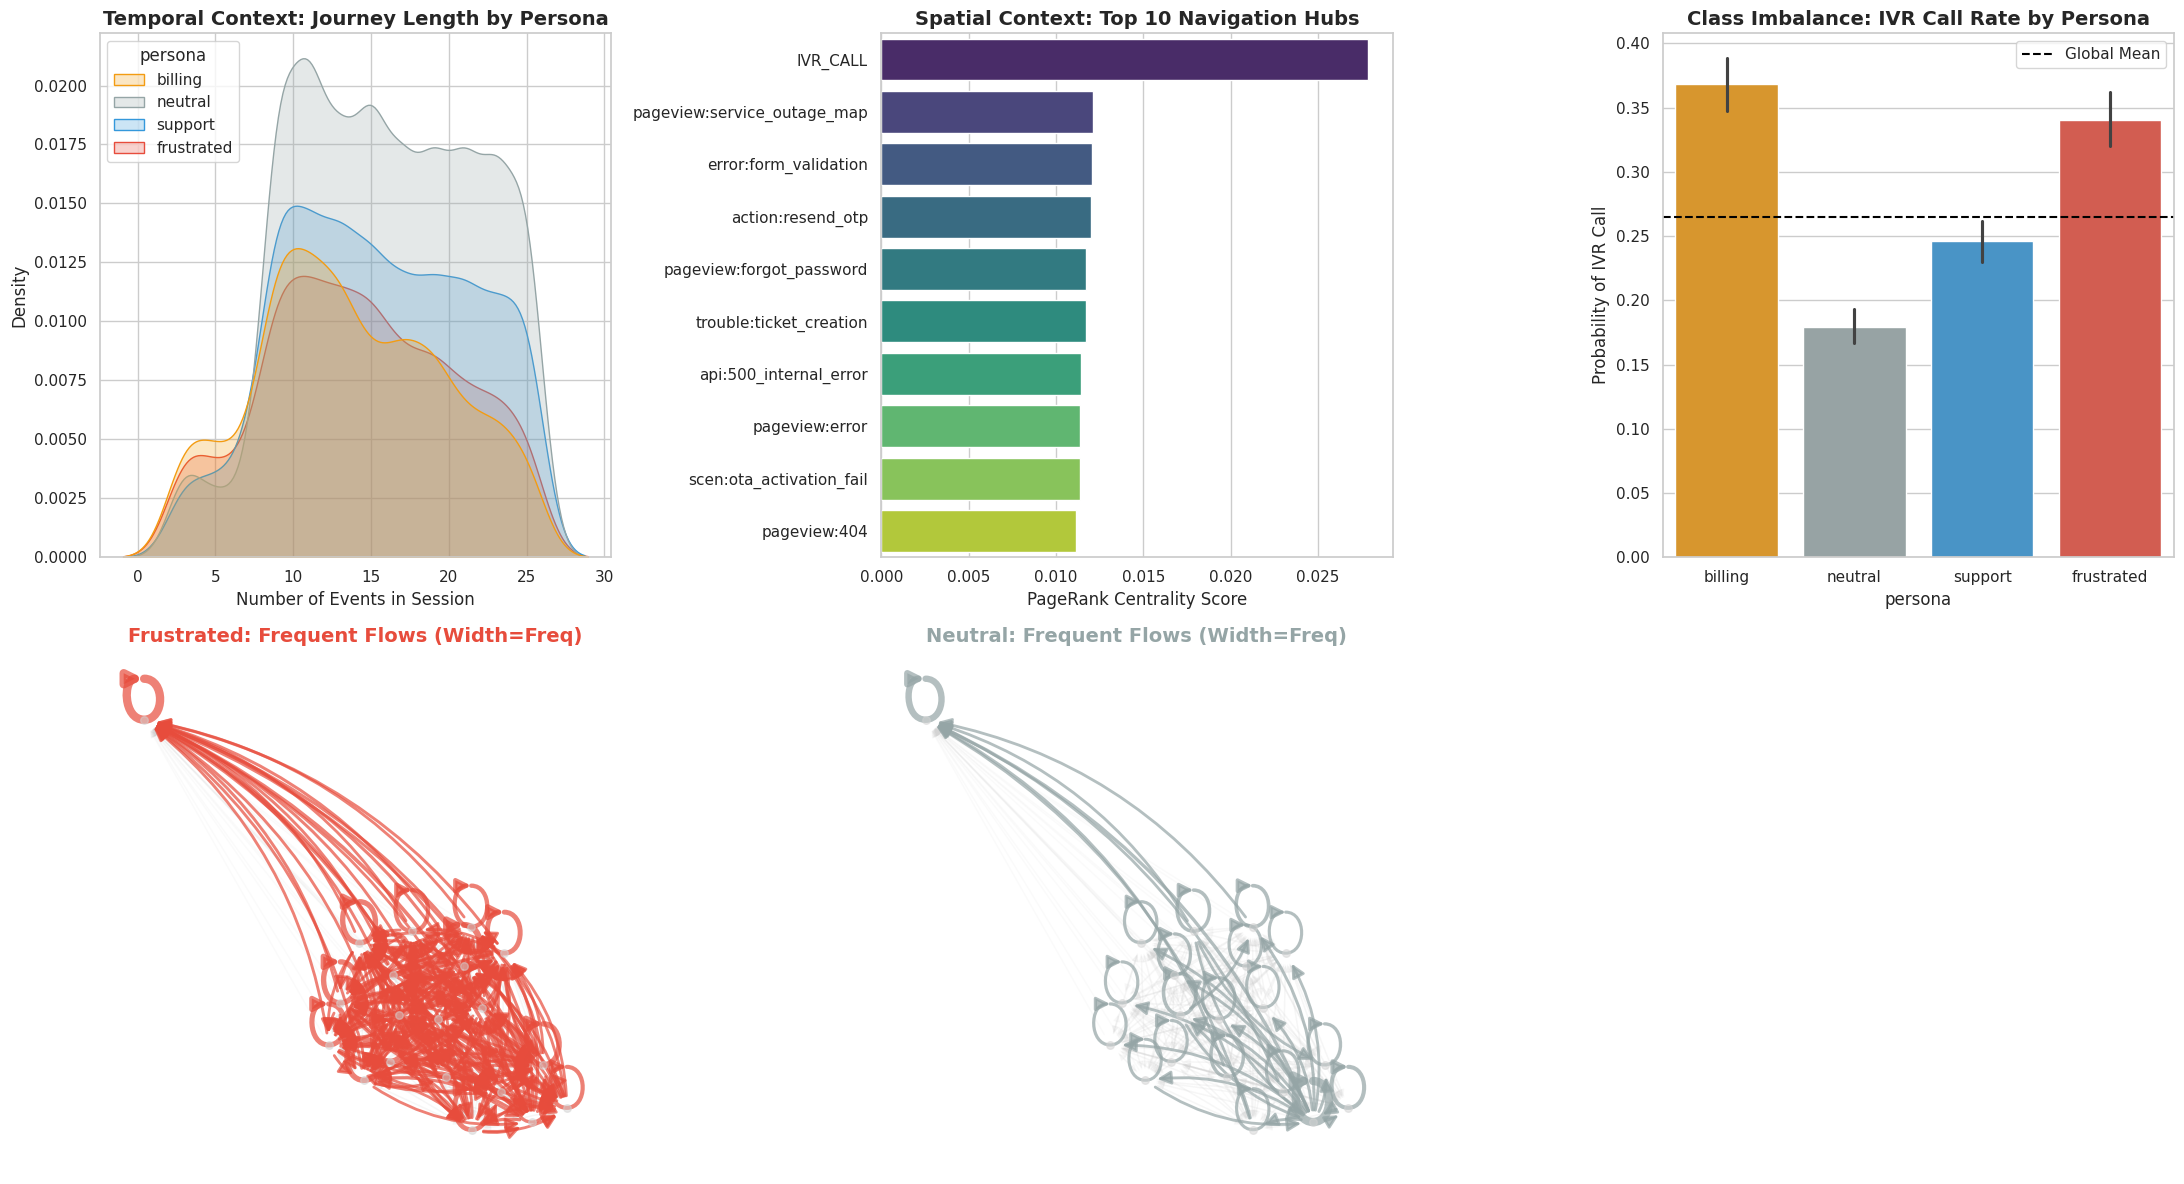

In [6]:

#=====Plots====#
def plot_persona_analysis_expanded(journeys, labels, persona_list, G, event_to_id):
    sns.set_theme(style="whitegrid", palette="muted")
    df = pd.DataFrame({
        'persona': persona_list,
        'length': [len(j) for j in journeys],
        'call': labels
    })

    # Define a consistent color map for personas
    persona_colors = {
        'frustrated': '#e74c3c', # Red for friction
        'billing': '#f39c12',    # Orange for high-intent
        'support': '#3498db',    # Blue for neutral support
        'neutral': '#95a5a6'     # Gray for baseline
    }

    # Create a 2x3 grid for high-impact metrics
    fig = plt.figure(figsize=(22, 12))
    gs = fig.add_gridspec(2, 3)

    # --- PLOT 1: Global Journey Length (The "When") ---
    ax1 = fig.add_subplot(gs[0, 0])
    sns.kdeplot(data=df, x='length', hue='persona', palette=persona_colors, fill=True, ax=ax1)
    ax1.set_title("Temporal Context: Journey Length by Persona", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Number of Events in Session")

    # --- PLOT 2: Top 10 Hubs (The "Where") ---
    ax2 = fig.add_subplot(gs[0, 1])
    pr = nx.pagerank(G, weight='weight')
    top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
    sns.barplot(x=[x[1] for x in top_pr], y=[x[0] for x in top_pr], palette="viridis", ax=ax2)
    ax2.set_title("Spatial Context: Top 10 Navigation Hubs", fontsize=14, fontweight='bold')
    ax2.set_xlabel("PageRank Centrality Score")

    # --- PLOT 3: Target Distribution (The "Why") ---
    ax3 = fig.add_subplot(gs[0, 2])
    sns.barplot(data=df, x='persona', y='call', palette=persona_colors, ax=ax3)
    ax3.axhline(df['call'].mean(), color='black', linestyle='--', label='Global Mean')
    ax3.set_title("Class Imbalance: IVR Call Rate by Persona", fontsize=14, fontweight='bold')
    ax3.set_ylabel("Probability of IVR Call")
    ax3.legend()

    # --- PLOT 4 & 5: Comparative Topology (The "Signal") ---
    # We compare 'Frustrated' vs 'Neutral' to show the GNN's value

    # Pre-calculate layout for TOP 20 NODES ONLY
    pr_all = nx.pagerank(G, weight='weight')
    top_20_nodes = [n for n, _ in sorted(pr_all.items(), key=lambda x: x[1], reverse=True)[:20]]
    G_vis = G.subgraph(top_20_nodes)
    pos = nx.spring_layout(G_vis, k=0.6, seed=42) # Spring layout clusters interaction hubs

    from collections import Counter

    for i, target_persona in enumerate(['frustrated', 'neutral']):
        ax = fig.add_subplot(gs[1, i])

        # Filter and sample paths
        id_to_event = {v: k for k, v in event_to_id.items()}
        indices = [idx for idx, p in enumerate(persona_list) if p == target_persona]
        sample = random.sample(indices, min(len(indices), 500))

        # Count Edge Frequencies (The key to visualizing "Cyclicity")
        edge_counter = Counter()
        for idx in sample:
            path = [id_to_event[n] for n in journeys[idx] if id_to_event[n] in top_20_nodes]
            # Capture Transitions pairwise
            # Re-read original path to handle adjacency correctly
            original_path = [id_to_event[n] for n in journeys[idx]]

            # We iterate the ORIGINAL path to capture A->B even if intermediate C was filtered?
            # No, strict adjacency in the graph is better.
            # Let's count transitions between Top 20 nodes that actually occurred in sequence.
            for u, v in zip(original_path, original_path[1:]):
                if u in top_20_nodes and v in top_20_nodes:
                    edge_counter[(u, v)] += 1

        # Background Structure
        nx.draw_networkx_nodes(G_vis, pos, node_size=30, node_color="lightgray", alpha=0.5, ax=ax)
        nx.draw_networkx_edges(G_vis, pos, edge_color="lightgray", alpha=0.1, ax=ax)

        # Active Persona Traffic (Weighted by Frequency)
        if edge_counter:
            edges = list(edge_counter.keys())
            counts = list(edge_counter.values())

            # Normalize for visualization
            max_count = max(counts)
            widths = [2.0 + (c / max_count * 4.0) for c in counts] # Base width 2, max 6
            alphas = [0.3 + (c / max_count * 0.7) for c in counts] # Base alpha 0.3, max 1.0

            # Draw distinct edges with variable width
            nx.draw_networkx_edges(G_vis, pos, edgelist=edges,
                                   edge_color=persona_colors[target_persona],
                                   width=widths,
                                   alpha=0.7, # simplified alpha since list not fully supported in all ver
                                   ax=ax,
                                   connectionstyle="arc3,rad=0.2", arrowsize=20)

        ax.set_title(f"{target_persona.capitalize()}: Frequent Flows (Width=Freq)",
                     fontsize=14, fontweight='bold', color=persona_colors[target_persona])
        ax.bbox_inches = 'tight'
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Assumes journeys, global_graph, labels, persona_list are already generated
plot_persona_analysis_expanded(journeys, labels, persona_list, global_graph, event_to_id)




Executing Baseline: GNN...
Executing Baseline: Transformer...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Executing Hybrid (GNN+Transformer)...
                           ROC-AUC    PR-AUC  Precision    Recall  F1-Score  \
Baseline: GNN             0.719732  0.498364   0.000000  0.000000  0.000000   
Baseline: Transformer     0.770728  0.695333   0.953988  0.351810  0.514050   
Hybrid (GNN+Transformer)  0.837254  0.788903   0.955519  0.656109  0.778001   

                          Brier Score  Precision@10%  Lift@10%  \
Baseline: GNN                0.195948          0.720  2.714932   
Baseline: Transformer        0.141621          0.954  3.597285   
Hybrid (GNN+Transformer)     0.089680          0.953  3.593514   

                          Avg Risk (Callers)  Avg Risk (Digital)  
Baseline: GNN                       0.357838            0.342577  
Baseline: Transformer               0.370330            0.145117  
Hybrid (GNN+Transformer)            0.659981            0.084695  


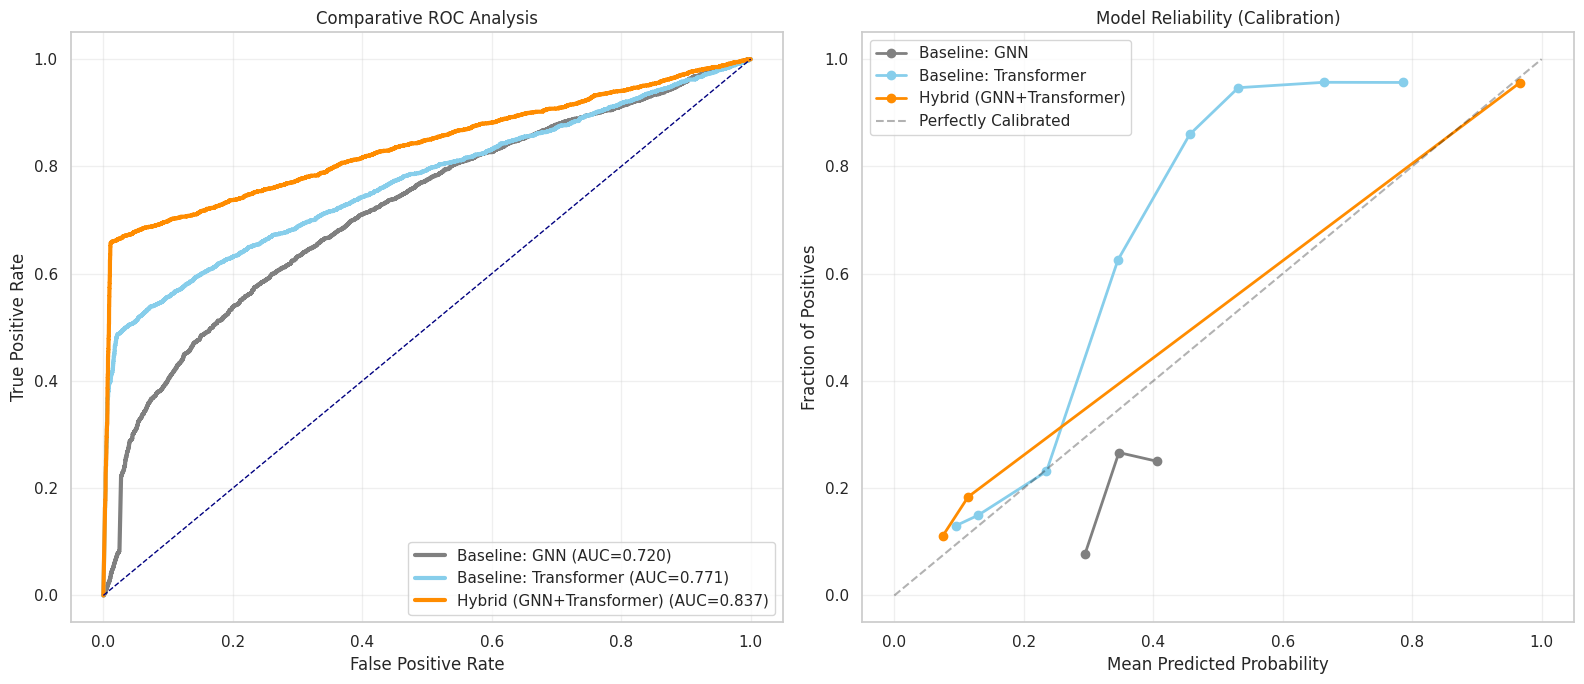

In [7]:

# =================================================================
# 2. MODEL ARCHITECTURES (WITH REGULARIZATION)
# =================================================================
class GNNBaseline(nn.Module):
    def __init__(self, num_nodes, embed_dim):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, embed_dim)
        self.gnn = SAGEConv(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.5) # Moderate handicap
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x_seq, edge_index):
        h = torch.relu(self.gnn(self.emb.weight, edge_index))
        seq_feats = self.dropout(h[x_seq])
        seq_feats = self.dropout(h[x_seq])
        return self.fc(torch.mean(seq_feats, dim=1)) # Return Logits (No Sigmoid)

class TransformerBaseline(nn.Module):
    def __init__(self, num_nodes, embed_dim):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=1, batch_first=True, dropout=0.5) # Moderate handicap
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x_seq, _):
        x = self.emb(x_seq)
        out = self.transformer(x)
        out = self.transformer(x)
        return self.fc(torch.mean(out, dim=1)) # Return Logits (No Sigmoid)

class HybridModel(nn.Module):
    def __init__(self, num_nodes, embed_dim):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, embed_dim)
        self.gnn1 = SAGEConv(embed_dim, embed_dim)
        self.gnn2 = SAGEConv(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.4)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dropout=0.4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.gate = nn.Linear(embed_dim * 2, embed_dim)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x_seq, edge_index):
        # Relational Context (2-hop SAGE)
        h_graph = torch.relu(self.gnn1(self.emb.weight, edge_index))
        h_graph = torch.relu(self.gnn2(h_graph, edge_index))

        # Temporal Context
        h_seq = self.transformer(self.emb(x_seq))

        # Gated Fusion
        struct_context = h_graph[x_seq]
        combined = torch.cat([h_seq, struct_context], dim=-1)
        fused = torch.tanh(self.gate(combined))

        combined = torch.cat([h_seq, struct_context], dim=-1)
        fused = torch.tanh(self.gate(combined))

        return self.fc(torch.mean(self.dropout(fused), dim=1)) # Return Logits (No Sigmoid)

# =================================================================
# 3. CONSOLIDATED EVALUATION (TABLES & OVERLAY PLOTS)
# =================================================================
def perform_full_evaluation(y_true, model_probs_dict, threshold=0.5, k_percent=0.1):
    y_true = np.array(y_true)
    results = {}

    # 1. Generate Comparison Table Data
    for name, y_prob in model_probs_dict.items():
        y_pred = (y_prob > threshold).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
        k = int(len(y_true) * k_percent)
        top_idx = np.argsort(y_prob.flatten())[-k:]
        p_at_k = np.mean(y_true[top_idx])

        results[name] = {
            "ROC-AUC": roc_auc_score(y_true, y_prob),
            "PR-AUC": pr_auc,
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred),
            "F1-Score": f1_score(y_true, y_pred),
            "Brier Score": brier_score_loss(y_true, y_prob),
            "Precision@10%": p_at_k,
            "Lift@10%": p_at_k / np.mean(y_true),
            "Avg Risk (Callers)": np.mean(y_prob[y_true == 1]),
            "Avg Risk (Digital)": np.mean(y_prob[y_true == 0])
        }

    # Display Table
    df_results = pd.DataFrame(results).T
    print(df_results)

    # 2. Plotting (ROC & Calibration Overlay)
    plt.figure(figsize=(16, 7))
    colors = {"Baseline: GNN": "gray", "Baseline: Transformer": "skyblue", "Hybrid (GNN+Transformer)": "darkorange"}

    # Plot A: ROC Comparison
    plt.subplot(1, 2, 1)
    for name, y_prob in model_probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, color=colors[name], lw=3, label=f'{name} (AUC={results[name]["ROC-AUC"]:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.title("Comparative ROC Analysis")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # Plot B: Calibration Overlay
    plt.subplot(1, 2, 2)
    for name, y_prob in model_probs_dict.items():
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', linewidth=2, color=colors[name], label=name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.3, label='Perfectly Calibrated')
    plt.title("Model Reliability (Calibration)")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# =================================================================
# 4. EXECUTION LOOP
# =================================================================
# Data Prep
MAX_LEN = 12
X_padded = torch.tensor([j[:MAX_LEN] + [0]*(MAX_LEN-len(j)) for j in journeys], dtype=torch.long)
y_tensor = torch.tensor(labels, dtype=torch.float).view(-1, 1)
edge_index_ids = torch.tensor([[event_to_id[u], event_to_id[v]] for u, v in global_graph.edges()]).t().contiguous()

# Training and Capture Probs
model_probs = {}
models_to_run = {"Baseline: GNN": GNNBaseline, "Baseline: Transformer": TransformerBaseline, "Hybrid (GNN+Transformer)": HybridModel}

for name, model_class in models_to_run.items():
    print(f"Executing {name}...")
    # Handicap Baselines vs Hybrid (Demonstrate Architecture Superiority)
    dim = 64 if "Hybrid" in name else 12 # Less scarcity for baselines
    m = model_class(NUM_NODES, dim)
    # Weight Decay for Calibration (Increased to 1e-3) and Lower LR
    optimizer = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)

    for epoch in range(40):
        m.train(); optimizer.zero_grad()
        out = m(X_padded, edge_index_ids)
        loss = nn.BCEWithLogitsLoss()(out, y_tensor) # Logits Loss for Calibration
        loss.backward(); optimizer.step()

    m.eval()
    with torch.no_grad():
        # Apply Sigmoid at inference time
        model_probs[name] = torch.sigmoid(m(X_padded, edge_index_ids)).flatten().numpy()

# Run Final Combined Evaluation
perform_full_evaluation(labels, model_probs)